In [1]:
import numpy as np
import math
import torch
from torch import nn

from Inference.EnsembleOfMAP import eMAP

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Inference.FuNNeVI import FuNNeVI
from Models import BigGenerator
from Metrics import RMSE, PICP, MPIW

from tempfile import TemporaryDirectory


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
from Experiments.foong import Setup
setup=Setup(device)


# Target density #

In [4]:
loglikelihood=setup.loglikelihood
projection=setup.projection

size_sample=setup.n_train_samples
param_count=setup.param_count
model=setup._model

X_train, y_train=setup.train_data()
X_test, y_test=setup.test_data()

def prior(n):
    return .5*torch.randn(size=(n,param_count), device=device)

size_sample,param_count

(120, 151)

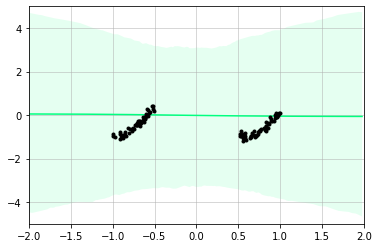

In [5]:
fig=setup.makePlotCI(prior(1000),device)

In [6]:
class LivePlotNotebook(object):
    """
    Live plot using %matplotlib notebook in jupyter notebook
    
    Usage:
    ```
    import time
    liveplot = LivePlotNotebook()
    x=np.random.random((10,))
    for i in range(10):
        time.sleep(1)
        liveplot.update(
            x=x+np.random.random(x.shape)/10,
            actions=np.random.randint(0, 3, size=(10,))
        )
    ```
    
    url:
    """

    def __init__(self, G, n=200):
        %matplotlib notebook
        fig, ax = plt.subplots(1, figsize=(18,18))
        fig.tight_layout
        self.n=n
        x_lin=torch.arange(-2.,2.,0.03).to(device)
        self.x_lin=x_lin
        
                
        ax.scatter(X_train.cpu(), y_train.cpu(), marker='.',color='black',zorder=4)
        
        theta_fake=G(n)
        for i in range(n):
            y_pred_fake = model(x_lin, theta_fake[i,:].unsqueeze(0))
            ax.plot(x_lin.detach().cpu().numpy(), y_pred_fake.squeeze(0).detach().cpu().numpy(), color='springgreen')
            
       
        
        self.ax = ax
        self.fig=fig

    def update(self, G):             
        # update price
        self.ax.clear()
        theta_fake=G(self.n)
        self.ax.scatter(X_train.cpu(), y_train.cpu(), marker='.',color='black',zorder=4)
        
        for i in range(self.n):
            y_pred_fake = model(self.x_lin, theta_fake[i,:].unsqueeze(0))
            self.ax.plot(self.x_lin.detach().cpu().numpy(), y_pred_fake.squeeze(0).detach().cpu().numpy(), color='springgreen')

        self.fig.canvas.draw()
        


# Generative Network #

In [7]:
lat_dim=5


G = BigGenerator(lat_dim,param_count,device).to(device)
#GeN= GeNetEns(1, lat_dim, 50, param_count, activation, 0.2, init_b, device)


<IPython.core.display.Javascript object>


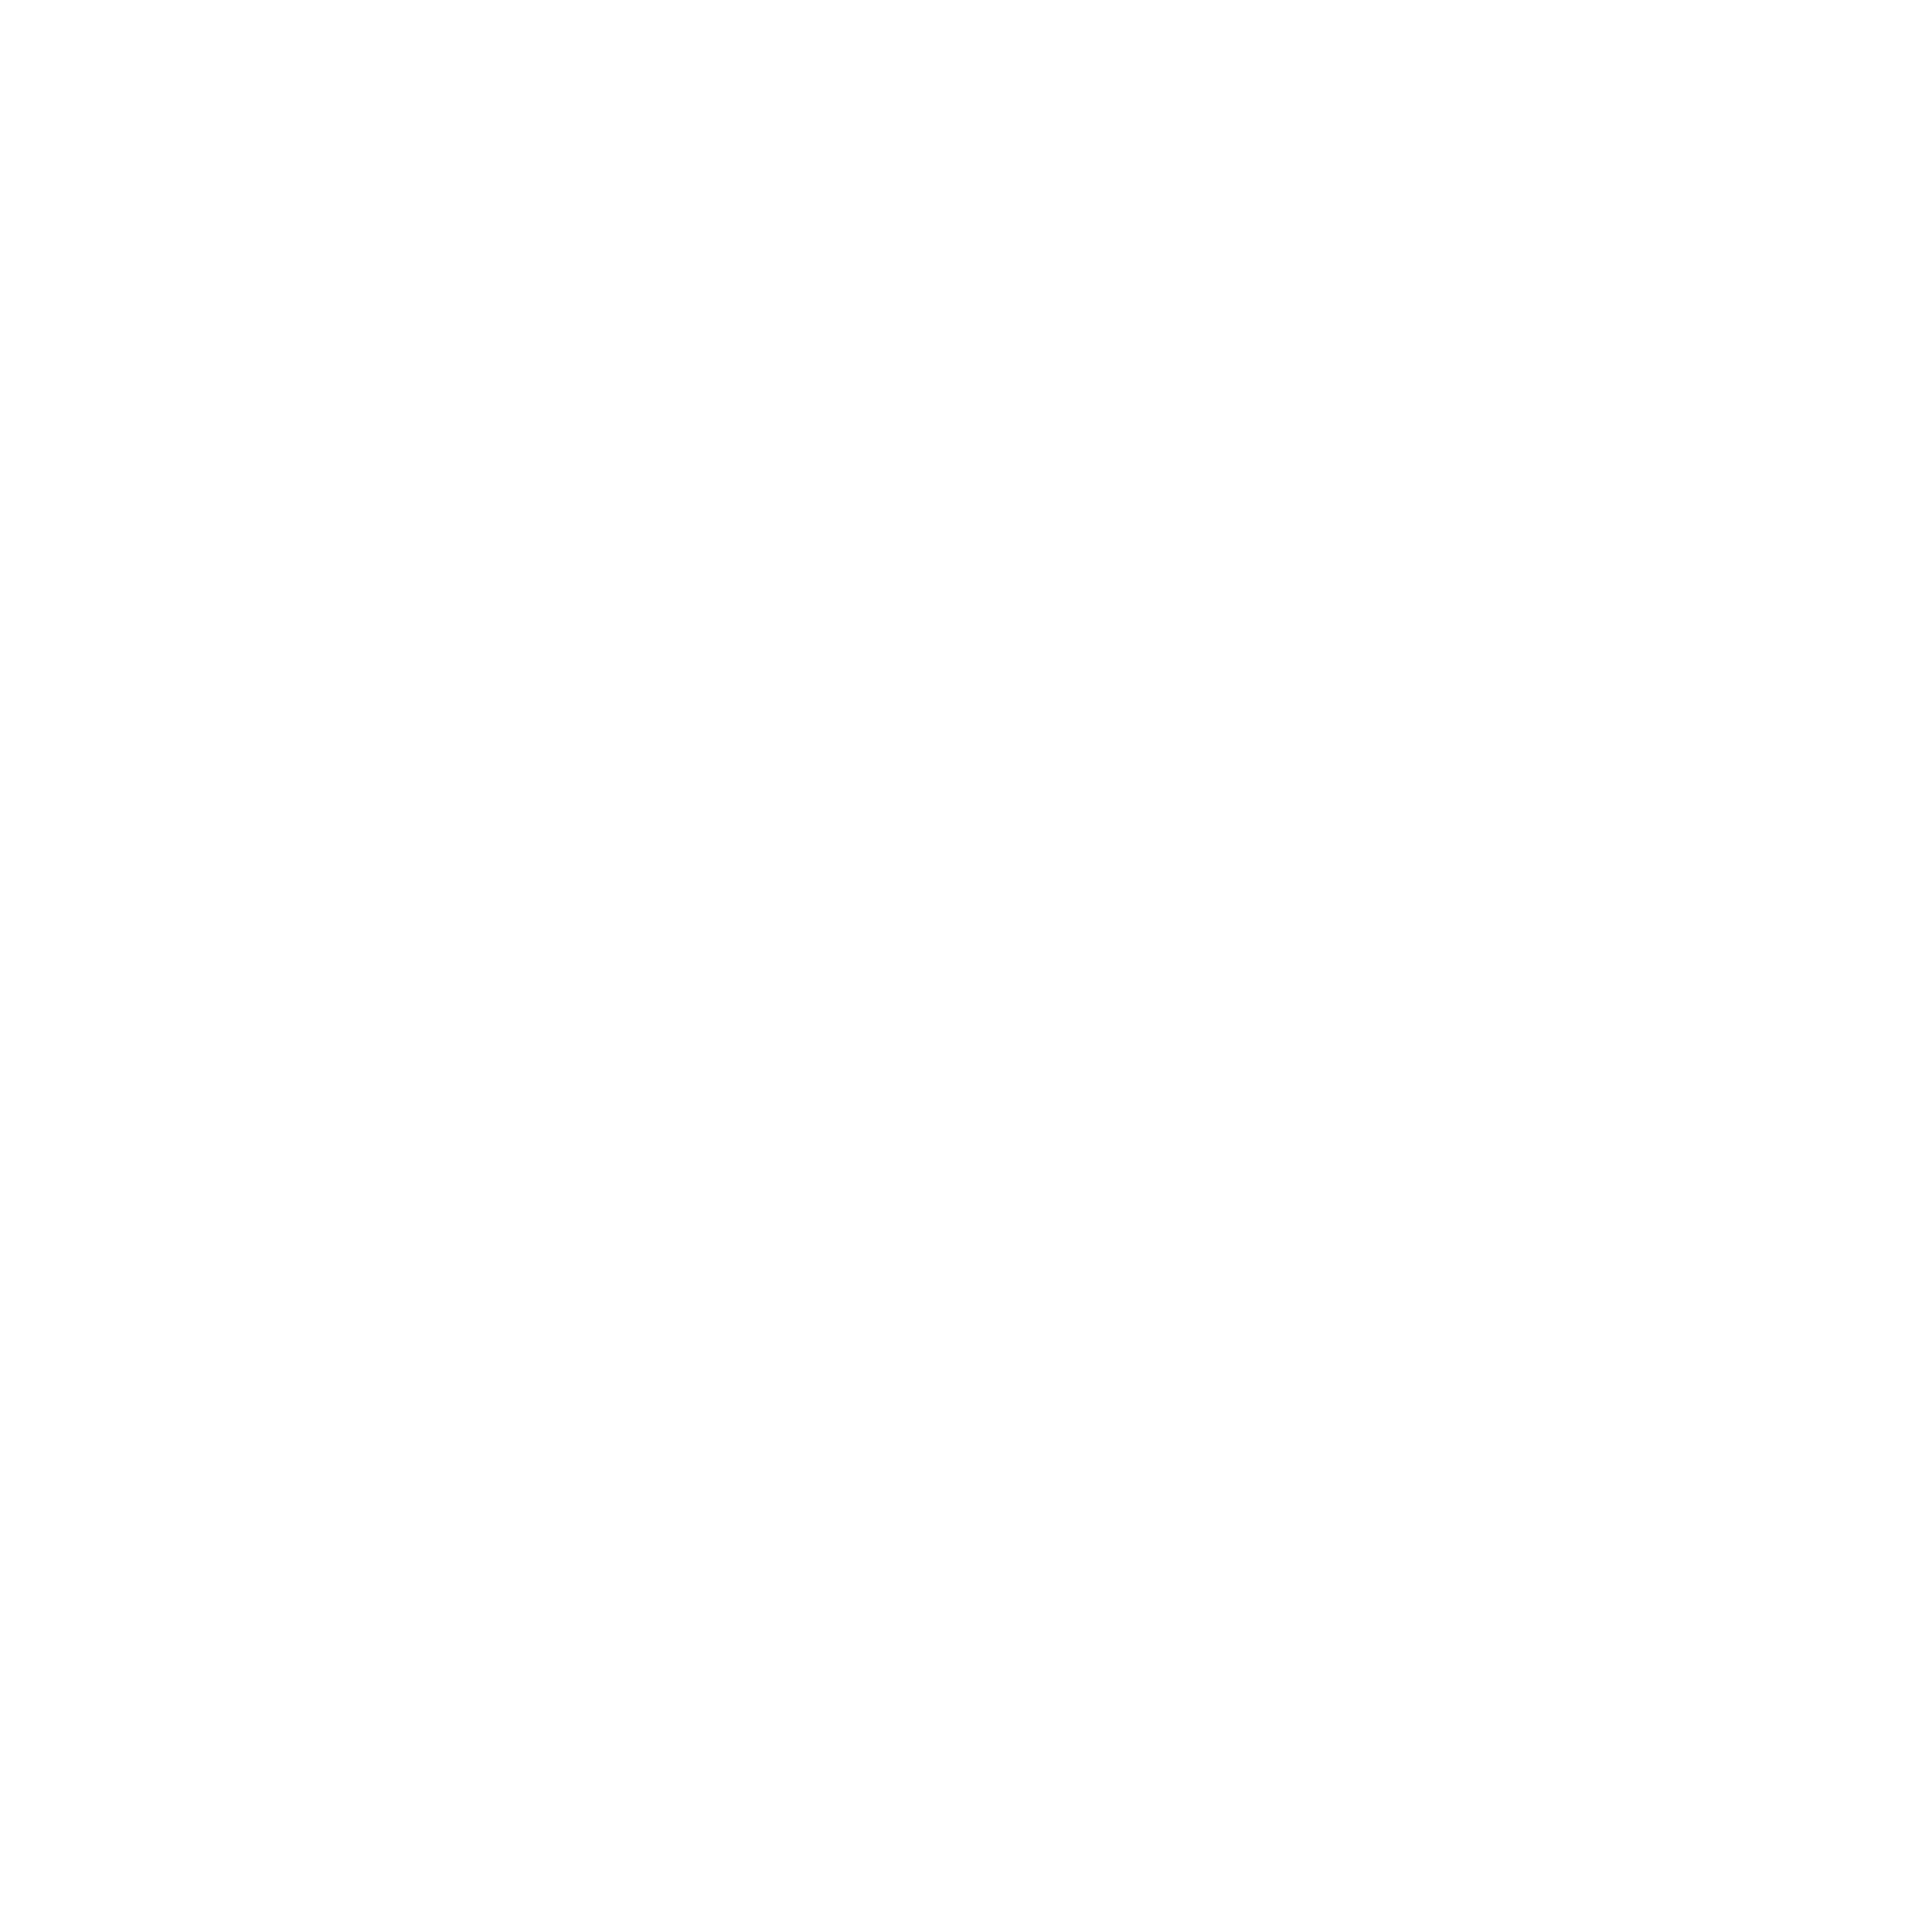

  6%|▌         | 572/10000 [00:45<12:32, 12.52it/s, ELBO=-27, KL=59.8, LogLike=86.8, lr=0.0035]       


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


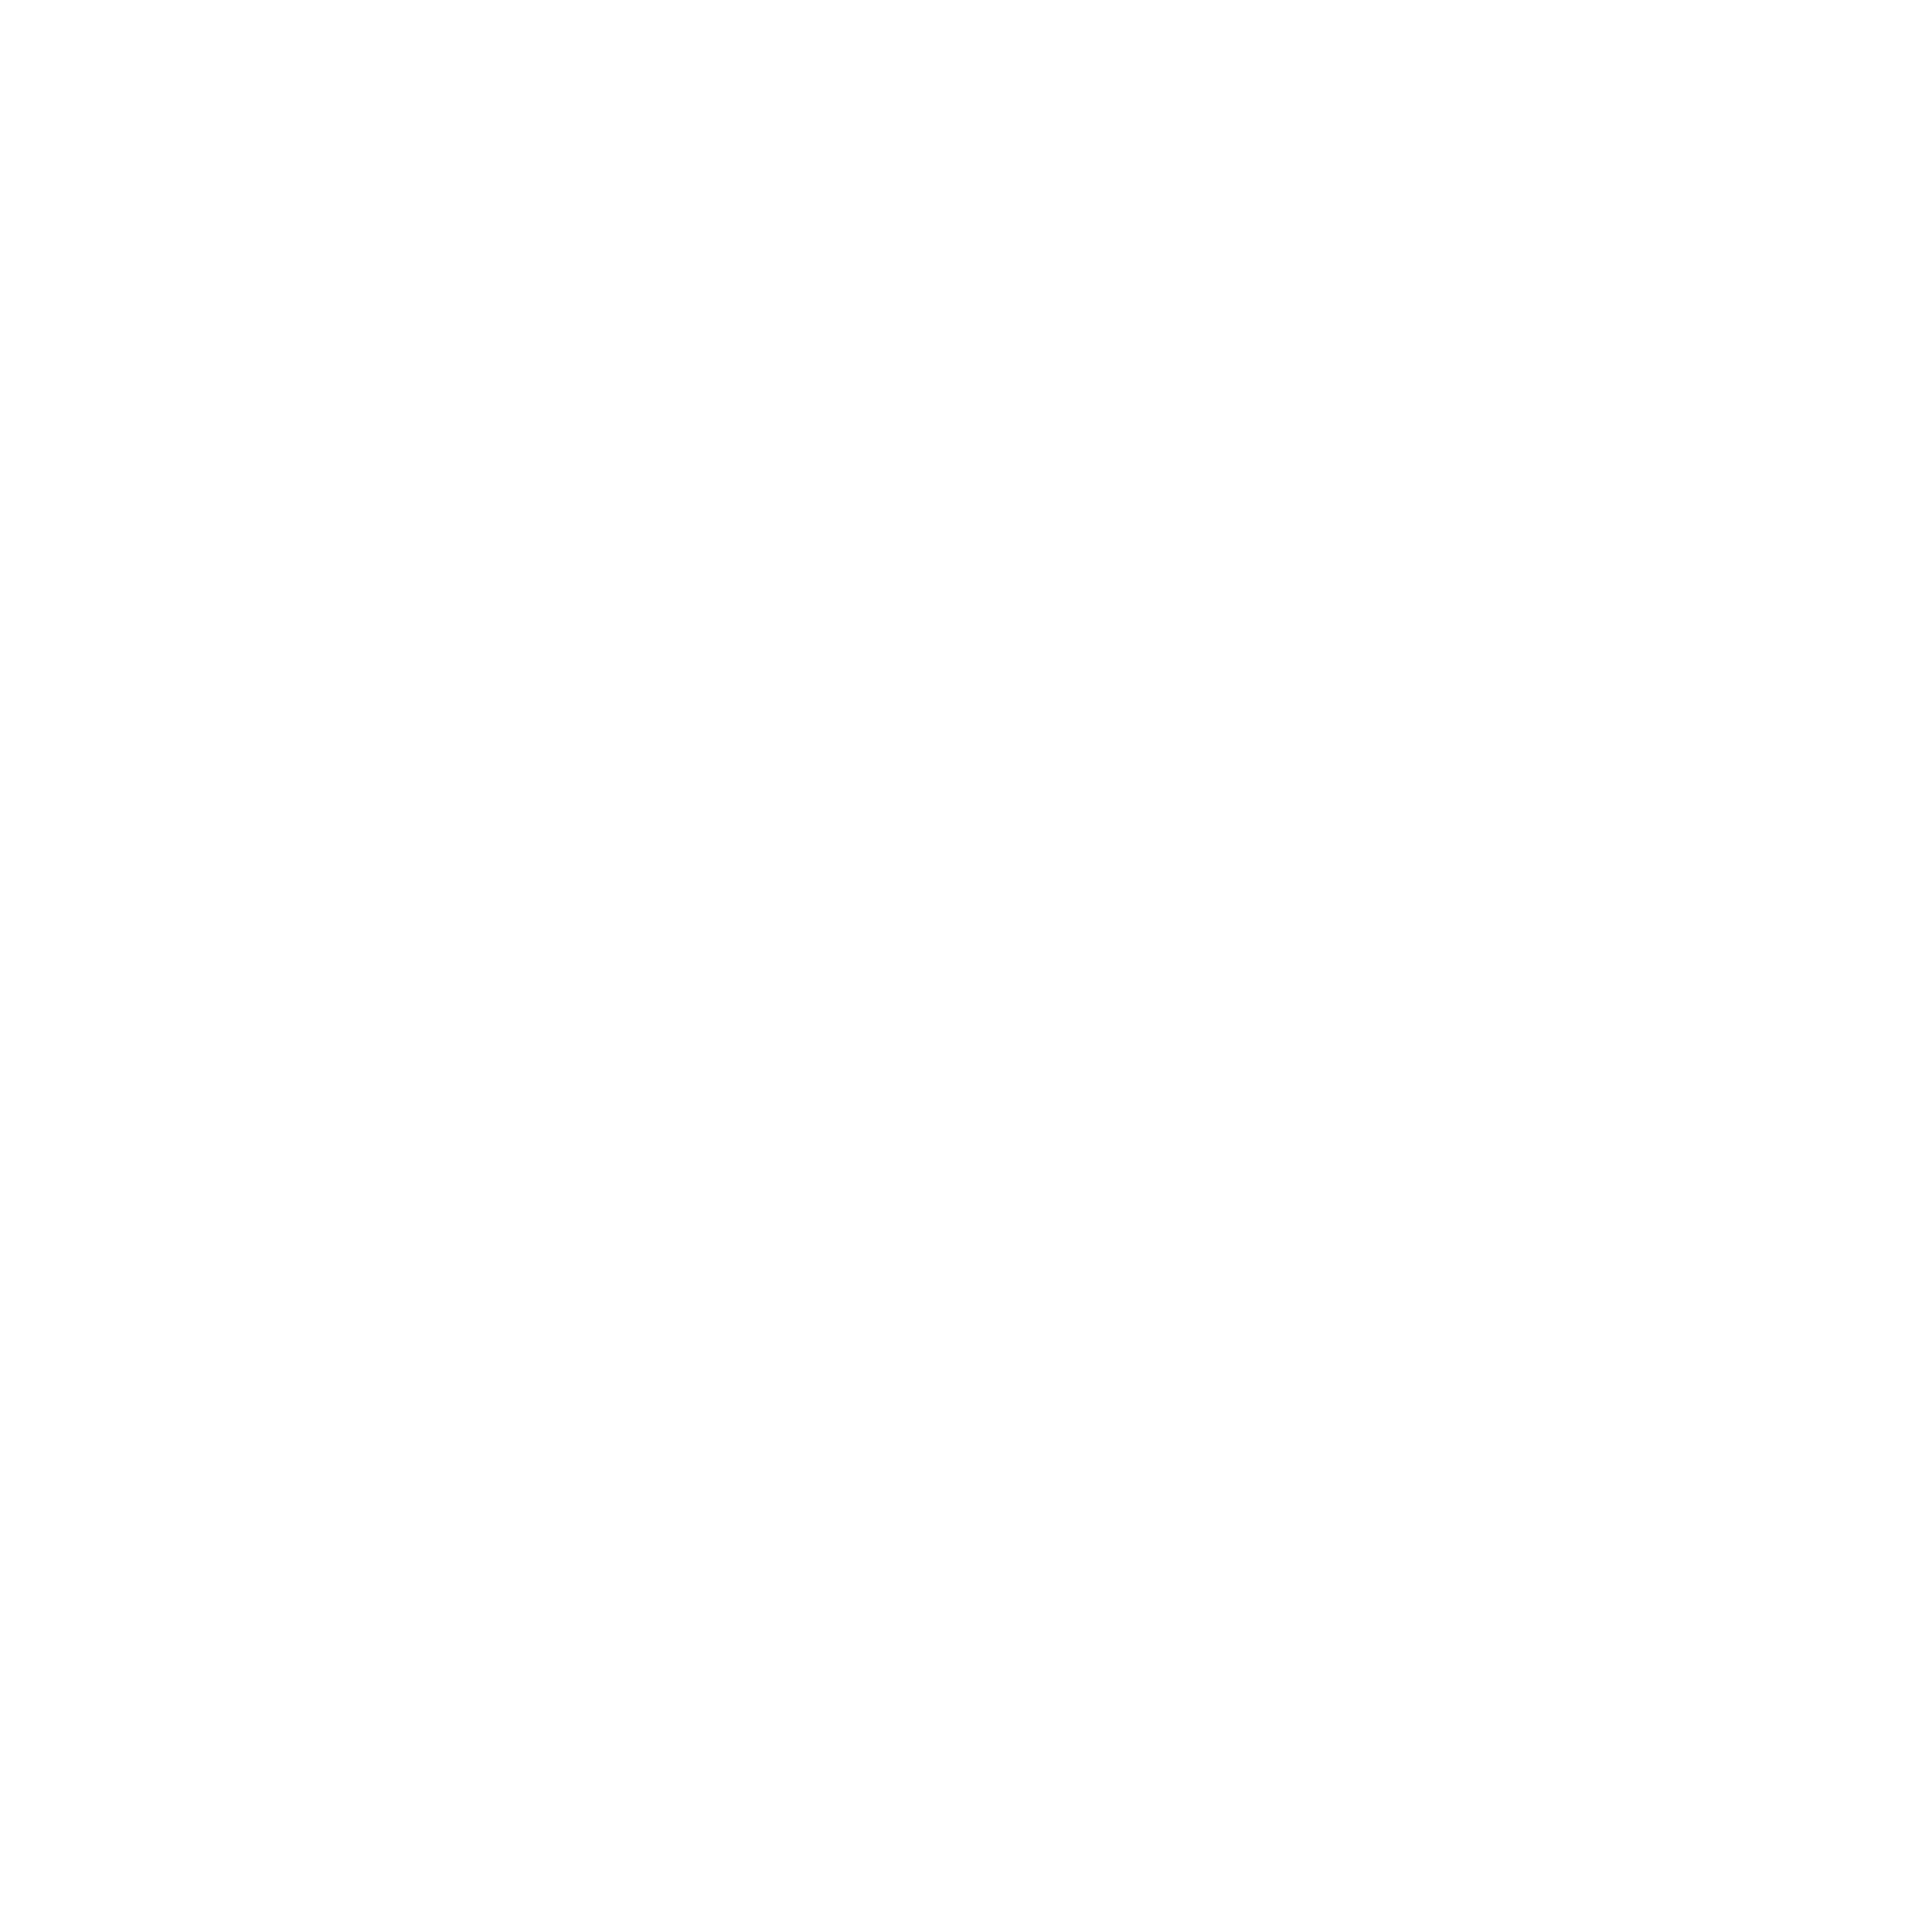

In [8]:
%matplotlib inline

liveplot=LivePlotNotebook(G,200)

optimizer = FuNNeVI(loglikelihood, size_sample, size_sample, prior, projection, n_samples_FU=20, ratio_ood=1., p=2,
                          kNNE=1, n_samples_KL=100, n_samples_LL=100, 
                          max_iter=10000, learning_rate=0.005, min_lr=1e-5, patience=100, lr_decay=0.7,
                          device=device, show=liveplot.update)
optimizer.run(G)

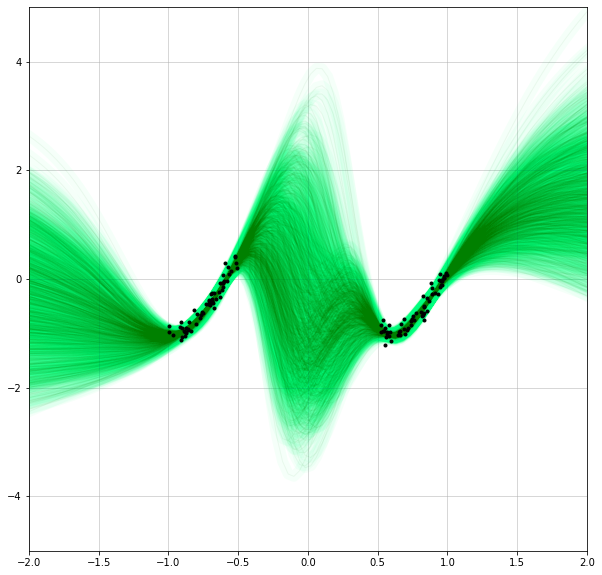

In [31]:
%matplotlib inline
fig=setup.makePlot(G(1000).detach(),device)